# Forecasting Competition - Predicting Gold Price
<img src="https://internationalbanker.com/wp-content/uploads/2021/12/Gold-Prices.png" alt="Drawing" style="width: 300px;"/>

## Imports
<hr>



In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ETSModel, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ETSModel, SimpleExpSmoothing, seasonal_decompose, Holt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "lines.linewidth": 2})
import warnings

import pmdarima as pm

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, cross_val_score
import lightgbm as lgb
import xgboost as xgb
from statsmodels.nonparametric.smoothers_lowess import lowess
warnings.filterwarnings("ignore",category=FutureWarning)

/Users/navyadahiya/opt/miniconda3/envs/mds574/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Forecasting Competition
<hr>



### Background and Tasks

In this week, we are going to have a live forecasting competition to predict the daily closing gold price from March 14th - March 18th. 

- You are provided with a real-time gold price dataset that refresh every day from Monday to Friday. 
- You are allowed to use as much or as little historical data as you want.
- You are allowed to use any forecasting/ML/deep learning techniques

Your tasks in this lab are simple:
1. Predict the daily closing gold price from March 14th - March 18th. Store it in a dataframe called `gold_predictions`
2. Make a plot of the training data and your predictions using any plotting library you wish. 
3. Your predictions will be evaluated 1 week after your lab's deadline.

In addition, please explain:

- Explain how far back did you use the historical data for training and why?
- Explain how you pre-process the data and how you engineer your features
- Explain which forecasting techniques did you use and why
- How you choose your parameters
- How did you deal with outliers?
- How do you evaluate your model performance & model fit?
- Reflect on the challenges that you encounter when working on this task


### Dataset

The dataset will refresh itself every weekday, so make sure to re-run the model on Saturday before submitting your results

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,1912.199951,1945.099976,1912.199951,1944.699951,1944.699951,154
2021-01-05,1941.699951,1952.699951,1941.300049,1952.699951,1952.699951,113
2021-01-06,1952.000000,1959.900024,1901.500000,1906.900024,1906.900024,331
2021-01-07,1922.599976,1926.699951,1912.000000,1912.300049,1912.300049,122
2021-01-08,1908.000000,1908.000000,1834.099976,1834.099976,1834.099976,60
...,...,...,...,...,...,...
2022-03-07,1989.000000,2001.099976,1963.000000,1993.900024,1993.900024,2516
2022-03-08,1999.400024,2072.000000,1998.000000,2040.099976,2040.099976,1813
2022-03-09,2053.600098,2063.000000,1980.800049,1985.900024,1985.900024,1022


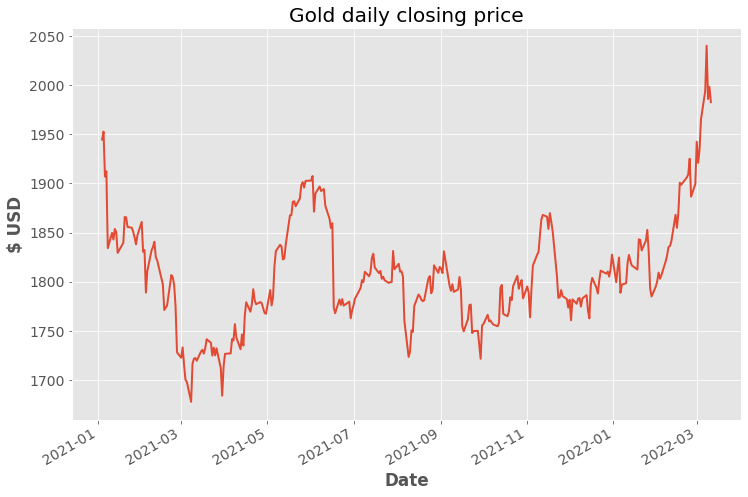

In [2]:
gold_df = yf.download('GC=F', 
                      start='2021-01-01', # YOU CAN CHANGE THIS
                      
                      end='2022-03-12', # DO NOT CHANGE THIS
                      progress=False)
gold_df['Close'].plot(title="Gold daily closing price", figsize=(12,8),ylabel='$ USD')
gold_df

### Predictions

Store your predictions in this dataframe

In [3]:
days = pd.date_range('2022-03-14', '2022-03-18', freq='D')
gold_predictions = pd.DataFrame({'Date': days,
                                 'Close_predict': [np.NaN]*5})
gold_predictions= gold_predictions.set_index('Date')
gold_predictions

,Close_predict
Date,
2022-03-14,NaN
2022-03-15,NaN
2022-03-16,NaN
2022-03-17,NaN
2022-03-18,NaN


### Evaluation

Following in the footsteps of the [M4 time series competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128), submissions will be evaluated based on the average of two metrics:
1. Symmetric mean absolute percentage error (MAPE)

$$\text{sMAPE}=\frac{2}{h}\sum_{t=n+1}^{n+h}\frac{|y_t-\hat{y_t}|}{|y_t|+|\hat{y_t}|}*100(\%)$$

2. Mean absolute scaled error (MASE)

$$\text{MASE}=\frac{1}{h}\frac{\sum_{t=n+1}^{n+h}|y_t-\hat{y_t}|}{\frac{1}{n-1}\sum_{t=2}^{n}|y_t-y_{t-1}|}$$

Where $y_t$ is the value of the series at time $t$, $\hat{y_t}$ is the forecast at time $t$, $h$ is the forecast horizon, $n$ is the number of training samples.

# Read in and inspect data

*Here we read in the data and re-sample to business day frequency.*

In [4]:
gold_df = yf.download(
    'GC=F', 
    start='2022-01-01',
    end='2022-03-12',
    progress=False
)

In [5]:
gold_df = gold_df.asfreq("b", method='pad')

In [6]:
gold_df.describe().round(3)

,Open,High,Low,Close,Adj Close,Volume
count,50.000,50.000,50.000,50.000,50.000,50.000
mean,1859.424,1871.482,1850.528,1862.170,1862.170,4980.800
std,65.675,72.611,59.760,64.958,64.958,27861.141
min,1787.100,1791.300,1778.800,1784.900,1784.900,4.000
25%,1812.425,1821.475,1804.525,1814.625,1814.625,51.000
50%,1831.700,1842.250,1827.100,1838.500,1838.500,294.000
75%,1905.025,1911.650,1890.775,1900.375,1900.375,728.000
max,2053.600,2072.000,1998.000,2040.100,2040.100,196036.000


In [7]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2022-01-03 to 2022-03-11
Freq: B
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       50 non-null     float64
 1   High       50 non-null     float64
 2   Low        50 non-null     float64
 3   Close      50 non-null     float64
 4   Adj Close  50 non-null     float64
 5   Volume     50 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 2.7 KB


# Check for NaNs

In [8]:
gold_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# Decompositions

* Below we try an additive and multiplicative decomposition to  understand trend and seasonality.  It looks like the series is additive as the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the value of the series and period of 3 looks reasonable here

## Additive Decomposition

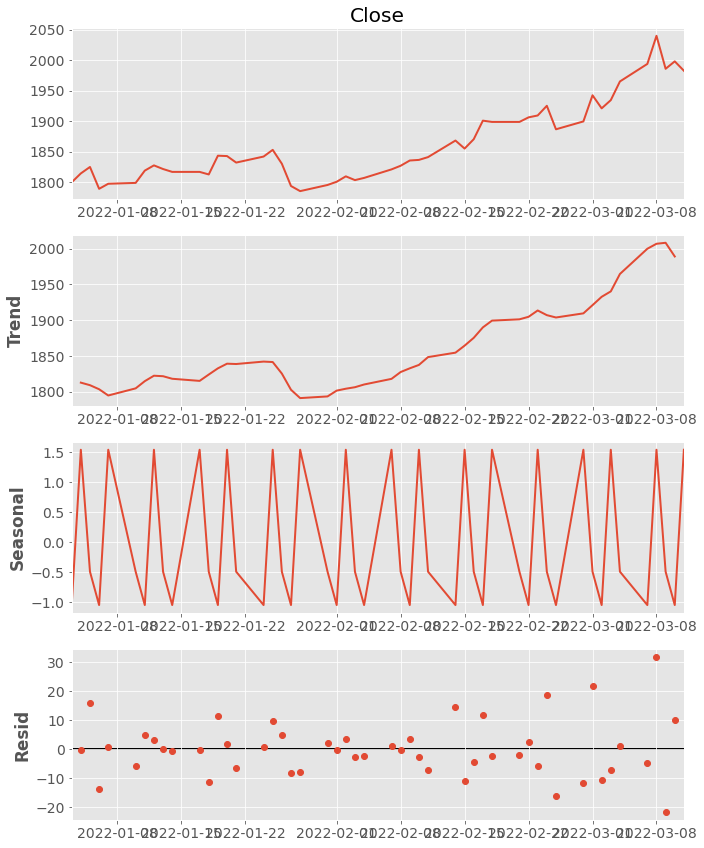

In [9]:
model = seasonal_decompose(gold_df["Close"], model="additive", period=3)

with matplotlib.rc_context():
    matplotlib.rc("figure", figsize=(10, 12))
    model.plot()
    plt.tight_layout()

## Multiplicative Decomposition

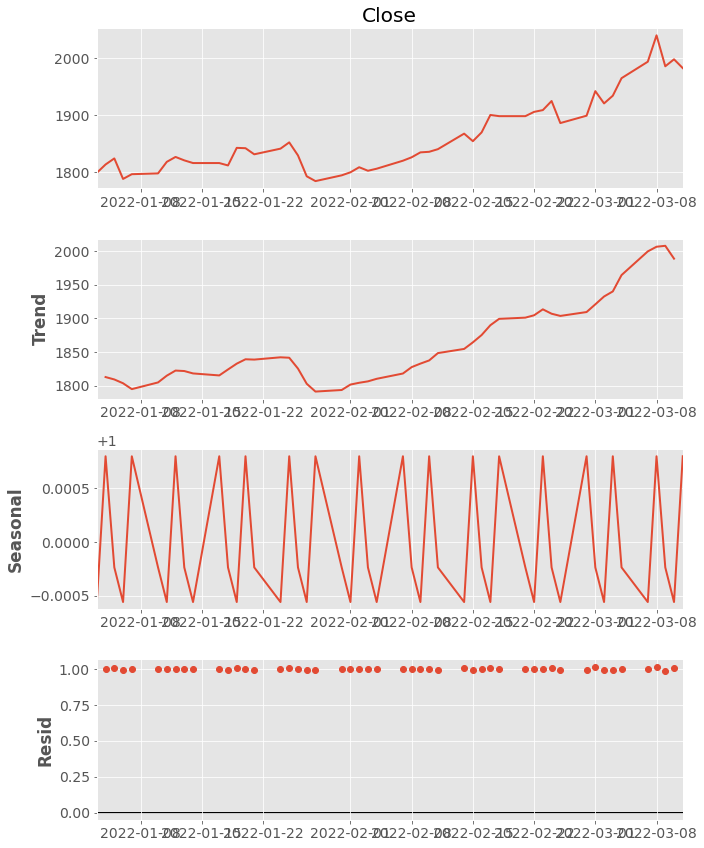

In [10]:
model = seasonal_decompose(gold_df["Close"], model="multiplicative", period=3)

with matplotlib.rc_context():
    matplotlib.rc("figure", figsize=(10, 12))
    model.plot()
    plt.tight_layout()

# Stationary Tests

## Helper functions

In [11]:
def stationary(df):
    """Take in a df, return log return in df_log, and first-order differencing in df_diff
       Make sure to drop na"""
    df_log, df_diff = (
        (np.log(df) - np.log(df.shift(1))).dropna(),
        df.diff().dropna()
    )

    return df_log, df_diff

In [13]:
def generate_plots(df, title, ylabel, lags=3):
    """Generates time, ACF, and PACF plots for a time series df"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    fig.suptitle(title, y=1.02, fontsize=25)
    axes[0].plot(df)
    axes[0].set_title("Time Plot")
    axes[0].set_ylabel(ylabel)
    plot_acf(df, ax=axes[1], lags=lags)
    plot_pacf(df, ax=axes[2], lags=lags);

## Untransformed data

* Here we look at if our data is stationary.  It looks like it is not, we will try log transformation and differencing to make it stationary

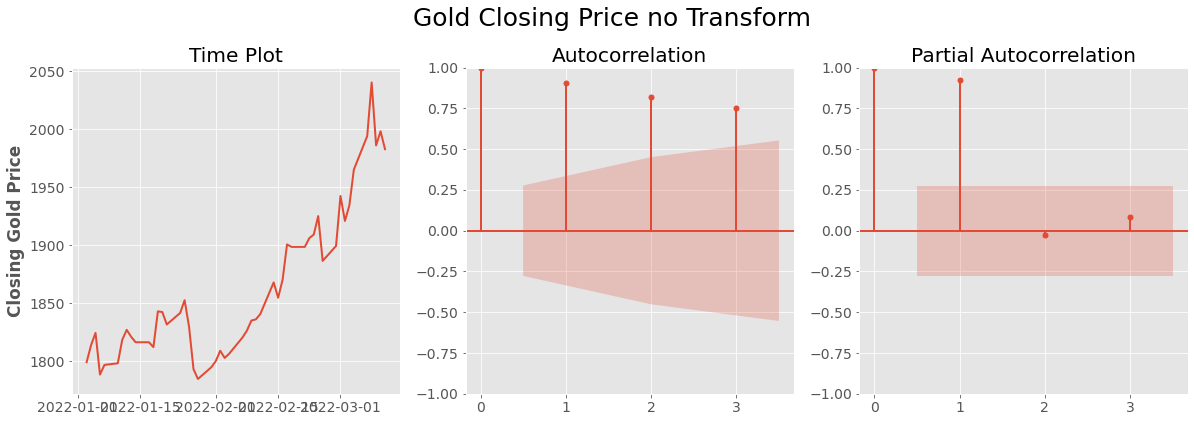

In [14]:
generate_plots(gold_df["Close"], "Gold Closing Price no Transform", "Closing Gold Price")

## Log transform

In [15]:
gold_log_df, gold_diff_df = stationary(gold_df["Close"])

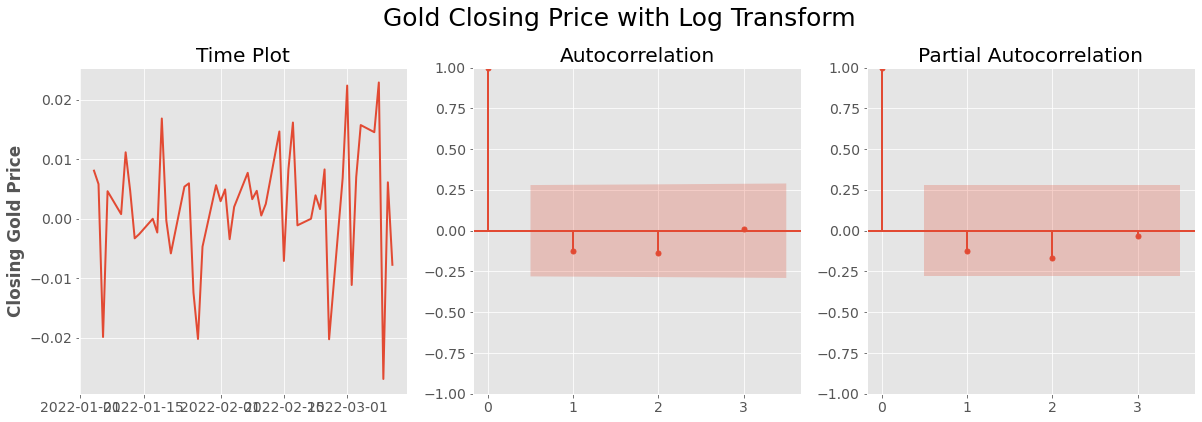

In [16]:
generate_plots(gold_log_df, "Gold Closing Price with Log Transform", "Closing Gold Price")

## 1st order differencing

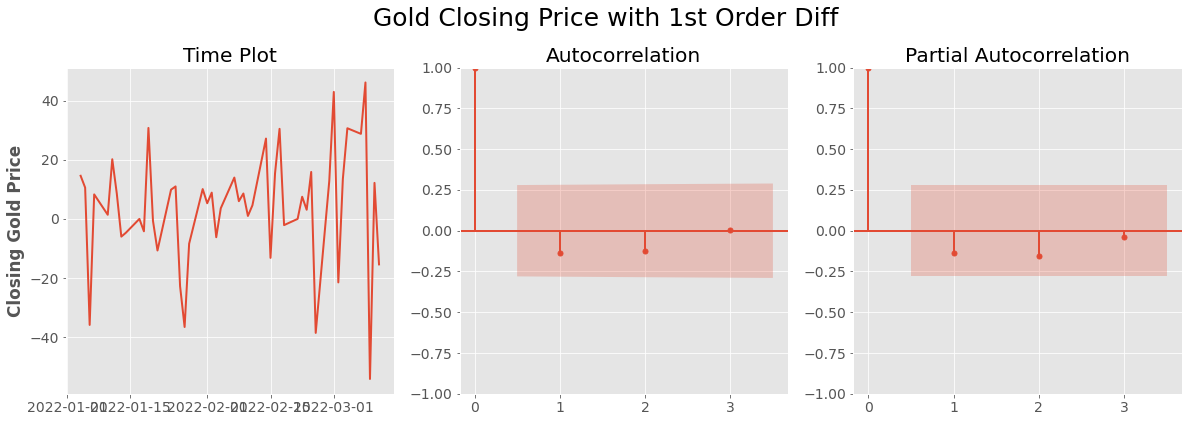

In [17]:
generate_plots(gold_diff_df, "Gold Closing Price with 1st Order Diff", "Closing Gold Price")

* Both log transformation and differencing make the series stationary. We will go ahead with log transformation, to account for the exponential increase in the series

# Modelling

*Here we do the following:*

- *Train test split without shuffling*
- *Train naive baseline model*
- *Train ETS model and Hotl-Winters model*
- *Train auto-ARIMA model*
- *Train SVM, XGBoost, LightGBM models*
- *Assess all the above models with metrics and plots*

## Helper functions and customer differencer

In [18]:
# functions adapted from lecture 4
def recursive_forecast(input_data, model, n=6, responses=1):
    forecast = np.empty((n, responses))
    for i, n in enumerate(range(n)):
        forecast[i] = model.predict(input_data.reshape(1, -1))
        input_data = np.append(forecast[i], input_data[:-responses])
    return forecast.reshape((-1, responses))


def lag_df(df, lag=1, cols=None):
    if cols is None:
        cols = df.columns
    return df.assign(
        **{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols}
    )


def recursive_diff_forecast(input_data, model, n=6):
    forecast = np.empty(n)
    for i, n in enumerate(range(n)):
        forecast[i] = model.predict(input_data)[-1]
        input_data = input_data.append(
            input_data.iloc[[-1]]
            .shift(1, axis=1)
            .fillna(forecast[i])
        )

    return forecast


# custom function
def get_recursive_pred(model, df, lag, index, label, diff=True):
    """Gets recursive predictions with or without differencing"""
    if diff:
        last_observations = df.iloc[-2:, :lag]

        results = pd.DataFrame(
            {
                "Close": recursive_diff_forecast(
                    last_observations,
                    model,
                    n=len(index)
                ).ravel(),
                "Label": label
            },
            index=index
        )
    else:
        last_observations = df.iloc[-1, :lag].to_numpy()

        results = pd.DataFrame(
            {
                "Close": recursive_forecast(
                    last_observations,
                    model,
                    n=len(index)
                ).ravel(),
                "Label": label
            },
            index=index
        )

    return results

In [19]:
# custom differencer for ML models from lecture 4
from sklearn.preprocessing import FunctionTransformer

differencer = FunctionTransformer(
    np.diff,
    inverse_func=np.cumsum,
    kw_args={"axis": 0, "prepend": 0},
    inv_kw_args={"axis": 0},
    validate=True
)

## Train, test, split

* We chose the training size to be 90% and test size to be 10%

In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    gold_df["Close"],
    test_size=0.1,
    random_state=42,
    shuffle=False
)

In [22]:
train.tail()

Date
2022-02-28    1899.400024
2022-03-01    1942.400024
2022-03-02    1920.900024
2022-03-03    1934.400024
2022-03-04    1965.099976
Freq: B, Name: Close, dtype: float64

In [23]:
test.head()

Date
2022-03-07    1993.900024
2022-03-08    2040.099976
2022-03-09    1985.900024
2022-03-10    1998.099976
2022-03-11    1982.699951
Freq: B, Name: Close, dtype: float64

## Outliers

* Fot detecting outliers, we would use the seasonal_decompose method as we have observed our series follows additive decomposition

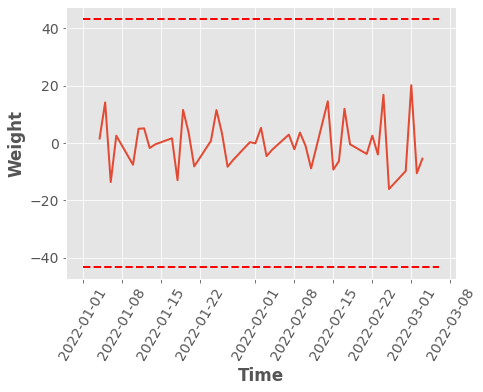

In [25]:

#code adapted from lecture notes
resid =  seasonal_decompose(train, model="additive", period=3).resid
q_01 = resid.quantile(0.1)
q_09 = resid.quantile(0.9)
upper_lim = 2 * (q_09 - q_01)
lower_lim = -2 * (q_09 - q_01)
outliers = np.where((resid > upper_lim) | (resid < lower_lim))[0]

#code adapted from 574 utils.py
def outlier_plot(df, outliers, lower_lim, upper_lim):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(df)
    xlim = plt.xlim()
    plt.plot(xlim, [lower_lim] * 2, "--r")
    plt.plot(xlim, [upper_lim] * 2, "--r")
    plt.plot(df.iloc[outliers], 'ro', ms=10)
    plt.xlabel("Time"), plt.xticks(rotation=60), plt.ylabel("Weight")
outlier_plot(resid, outliers, lower_lim, upper_lim)


* We observe that there are no outliers within the past 3 months in our series

## Forecast Index

In [26]:
forecast_index = test.index
steps = len(test)

## Naive Model

In [27]:
naive = pd.DataFrame(
    {
        "Close": train.iloc[-1],
        "Label": "Naive"
    },
    index=forecast_index
)

## Holt-Winter Model

In [28]:
holt_wint = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=3, initialization_method="estimated")
holt_wint = holt_wint.fit(method="least_squares")
holt_wint = pd.DataFrame({"Close": holt_wint.forecast(len(forecast_index)),
                        "Label": "Holt-Winters"},
                       index=forecast_index)

## ETS Model

In [29]:
ets_model = ETSModel(
    train,
    error="add",
    trend="add",
    seasonal="add",
    seasonal_periods=3
).fit(disp=False)

ets = pd.DataFrame(
    {
        "Close": ets_model.forecast(steps),
        "Label": "ETS"
    },
    index=forecast_index
)

In [31]:
ets_model.aic

398.5310406186153

## Auto-ARIMA

In [32]:

auto_ARIMA = pm.auto_arima(
    y=train,
    start_p=1,
    max_p=5,
    start_d=1,
    max_d=5,
    start_q=1,
    max_q=5,
    start_P=1,
    max_P=3,
    start_D=1,
    max_D=3,
    start_Q=1,
    max_Q=3,
    m=12,
    information_criterion="bic",
)

In [33]:
print(auto_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -188.478
Date:                Sat, 12 Mar 2022   AIC                            378.956
Time:                        10:24:19   BIC                            380.740
Sample:                             0   HQIC                           379.617
                                 - 45                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       307.7747     62.561      4.920      0.000     185.158     430.392
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.51   Pr

In [34]:
arima = pd.DataFrame(
    {
        "Close": auto_ARIMA.predict(steps),
        "Label": "Auto_ARIMA"
    },
    index=forecast_index
)

## ML Models

In [35]:
# convert to df for ML models
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(train)

In [36]:
#lags=3 to account for past 3 months data
lags = 3
lagged_df = lag_df(train_df, lag=lags, cols=["Close"]).dropna()

X_train = lagged_df.drop(columns=["Close"])
y_train = lagged_df["Close"]

In [37]:
results = {}

models = {
    "SVR_rbf": SVR(kernel="rbf"),
    "LightGBM": lgb.LGBMRegressor(),
    "XGBoost": xgb.XGBRegressor(),
}

for name, model in models.items():
    pipe = make_pipeline(differencer, model)
    fitted_pipe = pipe.fit(X_train, y_train)
    diff_label = f"{name} Recursive Diff Model"
    results[diff_label] = get_recursive_pred(fitted_pipe, lagged_df, lags, forecast_index, diff_label, True)

/Users/navyadahiya/opt/miniconda3/envs/mds574/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/Users/navyadahiya/opt/miniconda3/envs/mds574/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/Users/navyadahiya/opt/miniconda3/envs/mds574/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(


## Results

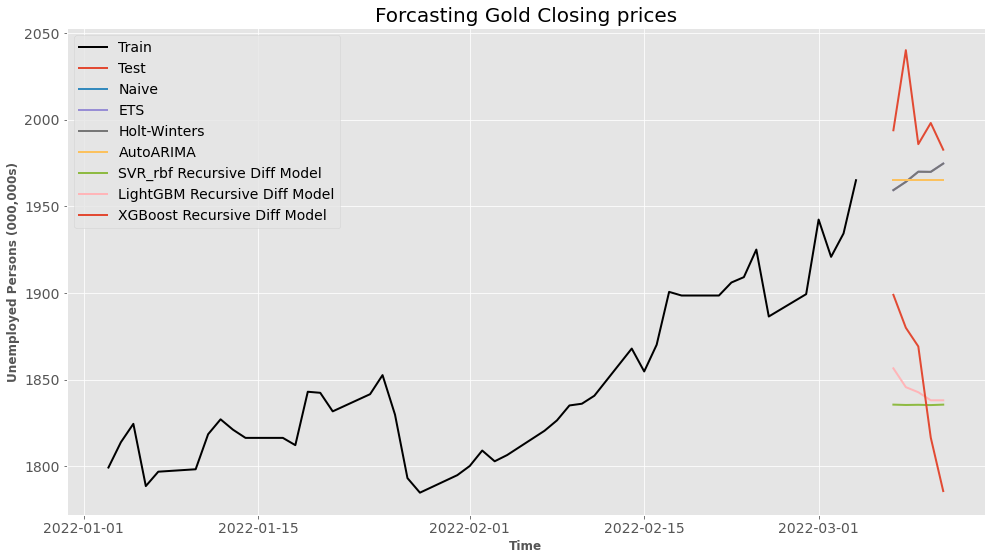

In [38]:
plt.figure(figsize=(14, 8))

# plot train and valid
plt.plot(
    train.index,
    train.sort_index(),
    label='Train',
    color="black"
)

plt.plot(test.index, test.values, label='Test')

# plot naive, ets,holt-winter and arima
plt.plot(naive.index, naive['Close'], label='Naive')
plt.plot(ets.index, ets['Close'], label='ETS')
plt.plot(holt_wint.index, holt_wint['Close'], label='Holt-Winters')
plt.plot(arima.index, arima['Close'], label='AutoARIMA')

# plot all ml models
for name, df in results.items():
    plt.plot(df.index, df['Close'], label=name)

# plot formatting
plt.title("Forcasting Gold Closing prices", fontsize=20)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Unemployed Persons (000,000s)", fontsize=12)
plt.legend(loc='best')
plt.tight_layout()
plt.show();

In [39]:
def smape(y_true, y_pred):
    c = 2 / len(y_true) * 100
    mape = np.sum(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

    return c * mape


def mase(y_true, y_pred, train_diff):
    c_1 = 1 / len(y_true)
    c_2 = 1 / (len(train_diff) - 1)
    num = np.sum(np.abs(y_true - y_pred))
    denom = c_2 * np.sum(np.abs(train_diff))
    
    return c_1 * num / denom


def metric(y_train, y_pred, train_diff):
    return (smape(y_true, y_pred) + mase(y_true, y_pred, train_dff)) / 2

In [40]:
y_true = test
train_dff = stationary(train)[1]

mape_df = pd.DataFrame(
    [
        metric(y_true, naive['Close'], train_dff),
        metric(y_true, ets['Close'], train_dff),
        metric(y_true, holt_wint['Close'], train_dff),
        metric(y_true, arima['Close'], train_dff),
        metric(y_true, results['SVR_rbf Recursive Diff Model']['Close'], train_dff),
        metric(y_true, results['LightGBM Recursive Diff Model']['Close'], train_dff),
        metric(y_true, results['XGBoost Recursive Diff Model']['Close'], train_dff),
    ],
    columns=["Avg sMAPE/MASE"],
    index=[
        "Naive",
        "ETS",
        "Holt-Winters",
        "AutoARIMA",
        "SVR_rbf Recursive Diff Model",
        "LightGBM Recursive Diff Model",
        "XGBoost Recursive Diff Model",
    ]
)

mape_df

,Avg sMAPE/MASE
Naive,2.160694
ETS,2.004106
Holt-Winters,2.004268
AutoARIMA,2.160694
SVR_rbf Recursive Diff Model,10.298312
LightGBM Recursive Diff Model,9.742211
XGBoost Recursive Diff Model,9.383551


# Predictions

*Here we retrain our best model (ETS) on all the data and make our final predictions.*

In [41]:
final_model = ETSModel(
    gold_df["Close"],
    error="add",
    trend="add",
    seasonal="add",
    seasonal_periods=3
).fit(disp=False)

In [42]:
days = pd.date_range('2022-03-14', '2022-03-18', freq='D')
gold_predictions = pd.DataFrame(
    {
        'Date': days,
        'Close_predict': final_model.forecast(len(days))
    }
)

gold_predictions = gold_predictions.set_index('Date')
gold_predictions

,Close_predict
Date,
2022-03-14,1989.115060
2022-03-15,1991.966445
2022-03-16,1997.989432
2022-03-17,2000.343602
2022-03-18,2003.194987


# Explanations

- **Explain how far back did you use the historical data for training and why?**

We only went back to January 2022 and are considering 3 months due to the ongoing war in Ukraine, which will likely cause a spike in gold prices and as we want to make predictions for a week only, more recent data makes more sense while predicting this.

- **Explain how you pre-process the data and how you engineer your features**

We did an additive and multiplicative decomposition to see if there was trend/seasonality.  Based on these, an additive decomposition worked better for us with the time period selected.  Further we plotted the ACF and PACF and noted significant autocorrelation.  To deal with this we used log transformation and differencing and chose to go ahead with log transformation to make the series stationary.  We did not feature engineer for our naive, ets or auto arima models.  We used lagged features for our ML models.

- **Explain which forecasting techniques did you use and why**

We used a naive model as our baseline.  Then, we used ETS, Auto-ARIMA, Holt-Winter and ML models.  We used these different types of models to have a diverse selection of models to choose from.(elaborate on why in final ans)

- **How you choose your parameters**

For ETS and Holt-winter, we tuned these manually.  For Auto-ARIMA, the algorithm itself tunes the parameters.  For ML, we used base models for SVM, LightGBM and XGBoost with no tuning. We chose iterations n=6 to avoid overfitting and lags = 3 to account for past 3 months' data for the ML models to learn from

- **How did you deal with outliers?**
We used the seasonal decompose method to detect outliers and found there were no outliers in the data for the time period we chose.

- **How do you evaluate your model performance & model fit?**
    - We have used different model selection metrics (in-sampled method, out-of-sample method) to determine how well the models fit our data.
    - For the in-sample method, we have used AIC and BIC as the model metrics to determine how well the models fit our data. The AIC and BIC score of auto-ARIMA was better than that of ETS. But it didn’t necessarily mean that auto-ARIMA outperformed ETS in terms of forecasting.
    - To account for the model performance on unseen data, we have split our data into train and validation sets (90:10). We set the naive model as our baseline model and evaluated our model forecast using the sMAPE, MASE and the average of the two metrics above. It was found that all the models other than ETS and Holt-Winters didn’t outperform better than the naive model. ETS model was found to be an appropriate model based on least volatility, the lowest average of sMAPE and MASE.

- **Reflect on the challenges that you encounter when working on this task**

    - Time series is very hard.  Especially predicting gold during a war which will be even harder with all volatility in the world that we cannot factor into our model. The most challenging task was to think of the `startDate`, as right now there is a surge in gold prices due to the ongoing war. But earlier, there were peaks in the gold prices due to inflation caused by covid. As it is a new day everyday for the gold prices, they are very much dependent on how stable the market is in the world and it keeps fluctuating.  
    - We found that the gold price forecasting is limited to long-term forecasting. We cannot figure out the relationship between short and long-run relationships after identifying spikes and breakpoints in the data sample. We also did not investigate other possible dependent variables (e,g, correlation with other mineral price movement, inflation, government gold reserves). For example, a change in the oil price may have a positive correlation with the gold price level. A further hypothesis test on the association with the variables above should be conducted to perform multivariate forecasting.
